In [1]:
import matplotlib
matplotlib.use('Agg')

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = Path('../../data/')
IMG_PATH = PATH/'cats'
CSV_PATH = PATH/'files.csv'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [5]:
fls = IMG_PATH.glob('cat.*.jpg')

In [6]:
with CSV_PATH.open('w') as fo:
    for f in fls: fo.write(f'{f.relative_to(IMG_PATH)},0\n')

In [7]:
sz=64

In [8]:
tfms = tfms_from_stats(inception_stats, sz)
md = ImageClassifierData.from_csv(PATH, IMG_PATH.relative_to(PATH), CSV_PATH, bs=8, tfms=tfms)

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [10]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize,cndf = isize/2,ndf
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1)
                                    for t in range(n_extra_layers)])

        pyr_layers = []
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)

In [11]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [12]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize!=isize: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]

        csize, cndf = 4, cngf
        while csize < isize//2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2

        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)

    def forward(self, input): return F.tanh(self.features(input))

In [13]:
x,_ = next(iter(md.val_dl))

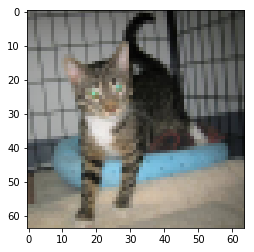

In [14]:
plt.imshow(md.trn_ds.denorm(x)[0])

In [15]:
nz = 100

In [24]:
bs = 8

In [16]:
netG = DCGAN_G(sz, nz, 3, 64, 1)
netD = DCGAN_D(sz, 3, 64, 1)

In [17]:
def create_noise(b): return V(torch.zeros(b, nz, 1, 1).normal_(0, 1)).cpu()

In [18]:
create_noise(4)

Variable containing:
( 0 , 0 ,.,.) = 
  0.3754

( 0 , 1 ,.,.) = 
  1.9215

( 0 , 2 ,.,.) = 
 -0.5769

( 0 , 3 ,.,.) = 
  0.1000

( 0 , 4 ,.,.) = 
  0.1695

( 0 , 5 ,.,.) = 
 -0.0311

( 0 , 6 ,.,.) = 
  0.9961

( 0 , 7 ,.,.) = 
 -0.5136

( 0 , 8 ,.,.) = 
  0.5827

( 0 , 9 ,.,.) = 
 -0.6438

( 0 ,10 ,.,.) = 
 -0.0102

( 0 ,11 ,.,.) = 
  2.1644

( 0 ,12 ,.,.) = 
  0.9088

( 0 ,13 ,.,.) = 
  0.6474

( 0 ,14 ,.,.) = 
 -1.8039

( 0 ,15 ,.,.) = 
  0.7265

( 0 ,16 ,.,.) = 
  0.5106

( 0 ,17 ,.,.) = 
  1.5432

( 0 ,18 ,.,.) = 
  0.2162

( 0 ,19 ,.,.) = 
  0.3890

( 0 ,20 ,.,.) = 
  1.6595

( 0 ,21 ,.,.) = 
  2.0563

( 0 ,22 ,.,.) = 
 -0.7868

( 0 ,23 ,.,.) = 
 -0.1750

( 0 ,24 ,.,.) = 
  0.5541

( 0 ,25 ,.,.) = 
 -1.1320

( 0 ,26 ,.,.) = 
 -0.2577

( 0 ,27 ,.,.) = 
 -0.6520

( 0 ,28 ,.,.) = 
  0.8752

( 0 ,29 ,.,.) = 
  1.8291

( 0 ,30 ,.,.) = 
 -1.0581

( 0 ,31 ,.,.) = 
  0.9237

( 0 ,32 ,.,.) = 
  0.6283

( 0 ,33 ,.,.) = 
  0.1787

( 0 ,34 ,.,.) = 
 -0.6063

( 0 ,35 ,.,.) = 
 -0.3911

( 0 ,36

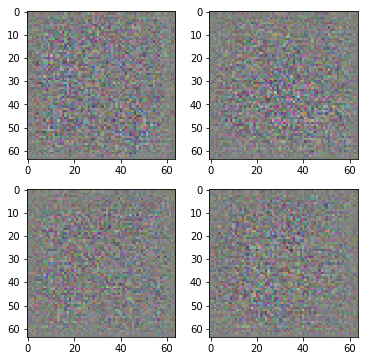

In [19]:
preds = netG(create_noise(4))
pred_ims = md.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

In [20]:
def gallery(x, nc=3):
    n,h,w,c = x.shape
    nr = n//nc
    assert n == nr*nc
    return (x.reshape(nr, nc, h, w, c)
              .swapaxes(1,2)
              .reshape(h*nr, w*nc, c))

In [21]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

In [22]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train(); netG.train()
        data_iter = iter(md.trn_dl)
        i,n = 0,len(md.trn_dl)
        with tqdm(total=n) as pbar:
            while i < n:
                set_trainable(netD, True)
                set_trainable(netG, False)
                d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5
                j = 0
                while (j < d_iters) and (i < n):
                    j += 1; i += 1
                    for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    real = V(next(data_iter)[0])
                    real_loss = netD(real)
                    fake = netG(create_noise(real.size(0)))
                    fake_loss = netD(V(fake.data))
                    netD.zero_grad()
                    lossD = real_loss-fake_loss
                    lossD.backward()
                    optimizerD.step()
                    pbar.update()

                set_trainable(netD, False)
                set_trainable(netG, True)
                netG.zero_grad()
                lossG = netD(netG(create_noise(bs))).mean(0).view(1)
                lossG.backward()
                optimizerG.step()
                gen_iterations += 1
            
        print(f'Loss_D {to_np(lossD)}; Loss_G {to_np(lossG)}; '
              f'D_real {to_np(real_loss)}; Loss_D_fake {to_np(fake_loss)}')

In [25]:
train(1, False)

100%|██████████| 23/23 [00:11<00:00,  2.25it/s]
Loss_D [-1.33974]; Loss_G [0.73789]; D_real [-0.64902]; Loss_D_fake [0.69072]
100%|██████████| 1/1 [00:11<00:00, 11.98s/it]

In [26]:
train(20, False)

100%|██████████| 23/23 [00:13<00:00,  2.06it/s]
Loss_D [-1.42647]; Loss_G [0.75446]; D_real [-0.70293]; Loss_D_fake [0.72354]
100%|██████████| 23/23 [00:19<00:00,  1.55it/s]
Loss_D [-1.38316]; Loss_G [0.73372]; D_real [-0.68655]; Loss_D_fake [0.69662]
100%|██████████| 23/23 [00:13<00:00,  2.21it/s]
Loss_D [-1.43367]; Loss_G [0.74601]; D_real [-0.70811]; Loss_D_fake [0.72556]
100%|██████████| 23/23 [00:12<00:00,  2.17it/s]
Loss_D [-1.4827]; Loss_G [0.76651]; D_real [-0.73597]; Loss_D_fake [0.74672]
100%|██████████| 23/23 [00:13<00:00,  1.84it/s]
Loss_D [-1.48127]; Loss_G [0.7575]; D_real [-0.73189]; Loss_D_fake [0.74938]
100%|██████████| 23/23 [00:14<00:00,  1.29it/s]
Loss_D [-1.19387]; Loss_G [0.75023]; D_real [-0.71029]; Loss_D_fake [0.48357]
100%|██████████| 23/23 [00:15<00:00,  1.49it/s]
Loss_D [-1.50502]; Loss_G [0.76647]; D_real [-0.75417]; Loss_D_fake [0.75085]
100%|██████████| 23/23 [00:19<00:00,  1.59it/s]
Loss_D [-1.28954]; Loss_G [0.64803]; D_real [-0.63747]; Loss_D_fake [0.6

In [32]:
set_trainable(netD, True)
set_trainable(netG, True)
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-5)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-5)

In [33]:
train(1, False)

100%|██████████| 23/23 [00:11<00:00,  2.43it/s]
Loss_D [-1.44007]; Loss_G [0.74998]; D_real [-0.71773]; Loss_D_fake [0.72234]
100%|██████████| 1/1 [00:12<00:00, 12.00s/it]

In [28]:
fixed_noise = create_noise(bs)

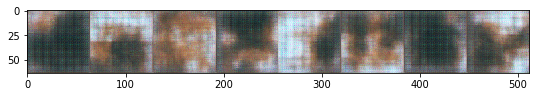

In [35]:
netD.eval(); netG.eval();
fake = netG(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake),0,1)

plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8));